# Structure-to-spectroscopy forward model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')  # optional

# I have a PyG version that prints a specific but otherwise harmless warning.
import warnings; warnings.filterwarnings('ignore', '.*TypedStorage is deprecated.*')

## Training structure-to-spectroscopy forward model

### Create lightning datamodule and module instances

A lot of details are hidden away for your convenience using PyTorch Lightning. They include:
- How the data is loaded, processed, batched, and so on.
- Forward GNN model definition.
- How the model is trained, which optimizer, exponential moving average, etc.

These implementations can be found at `./lit/` if you are interested.

In [2]:
from lit.datamodules import StructureXANESDataModule
from lit.modules import LitXANESNet

datamodule = StructureXANESDataModule(
    data_dir    = './data/a-C/dgp/',  # where the data is
    cutoff      = 3.0,                # cutoff fradius for atomic graph construction
    train_prior = False,              # whether this data module is used for training a prior score model
    k           = 0.8,                # maximum noise level to be applied (irrelevant if training forward model)
    train_size  = 0.9,                # used for train-validation split (irrelevant if training prior score model)
    scale_y     = 1.0,                # scale the spectroscopy curve (irrelevant if training prior score model)
    dup         = 1,                  # duplicate data for longer epochs
    batch_size  = 8,                  # number of structure frames in a single batch
    num_workers = 4,                  # number of workers for the dataloader
)

# New model instance
# xanes_net = LitXANESNet(num_species=1,num_convs=3, dim=128, out_dim=100, learn_rate=0.001)

# Load model weights from a saved checkpoint
xanes_net = LitXANESNet.load_from_checkpoint(
    './lit_logs/forward-a-C-r3/version_3/checkpoints/epoch=124-step=100000.ckpt'
)

### Start training session

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

MAX_STEPS = 100_000
RUN_NAME  = 'forward-a-C-r3'
CKPT_PATH = None  # specify this if you are resuming from a previous training session

logger = TensorBoardLogger(save_dir='./lit_logs/', name=RUN_NAME)
callbacks = [TQDMProgressBar(refresh_rate=8)]
trainer = pl.Trainer(logger=logger, max_steps=MAX_STEPS, callbacks=callbacks)
trainer.fit(xanes_net, datamodule, ckpt_path=CKPT_PATH)

## Validation

### Predict on validation data

Note that the train-validation split is done over individual atoms, not frames/images. In other words, if we have some structure frames totaling 1,000 atoms. Using `train_size=0.9` means that roughly 900 randomly selected atoms are used for training, regardless of the number of frames.

In [3]:
xanes_net.to('cpu')
datamodule.setup()

all_pred_y, all_true_y = [], []
with torch.no_grad():
    for data in datamodule.train_dataloader():
        pred_y = xanes_net.ema_model(data.z, data.edge_index, data.edge_attr)
        all_pred_y.append(pred_y[~data.train_mask])
        all_true_y.append(data.y[~data.train_mask])

all_pred_y = torch.vstack(all_pred_y)
all_true_y = torch.vstack(all_true_y)

losses = (all_pred_y - all_true_y).square().mean(dim=1)

### Plot randomly sampled predictions

Note that the GNN prediction is node-centric; the model predicts **per-atom** spectroscopy curves. Here a subset of validation atoms and their corresponding predicted spectra are plotted.

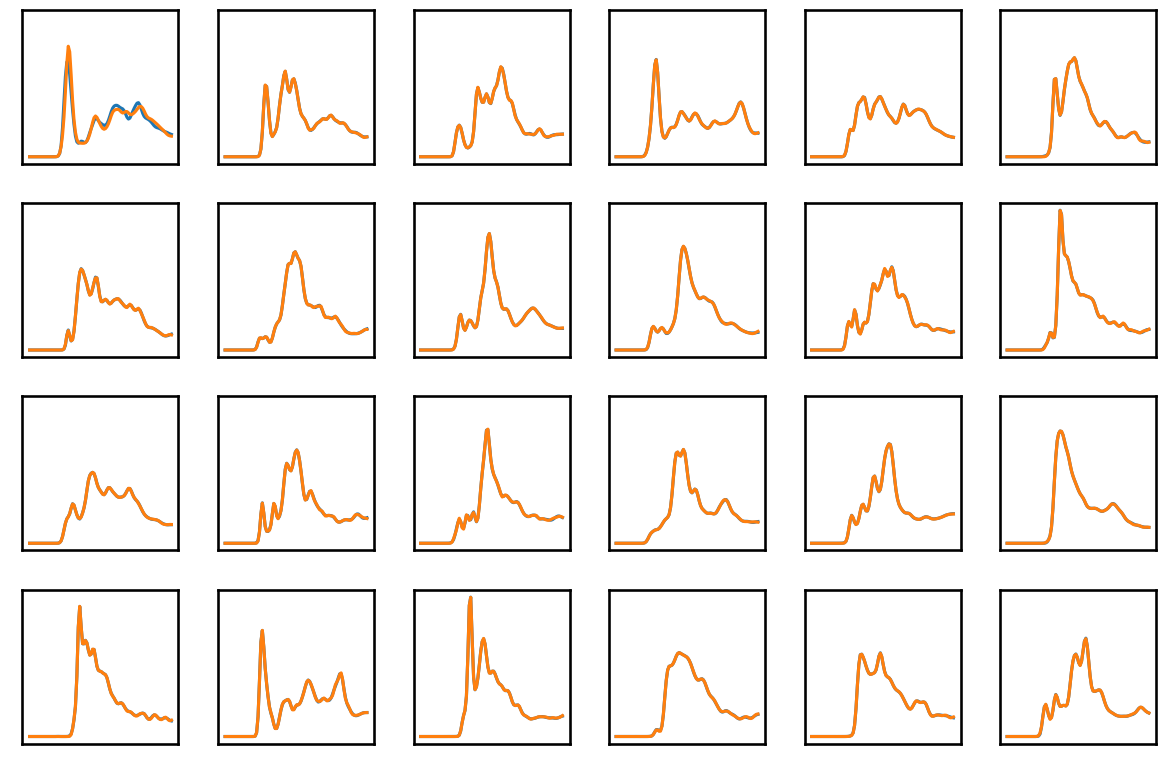

In [6]:
import random

NROWS, NCOLS = 4, 6

k = NROWS*NCOLS
rand_idx = random.choices(np.arange(len(losses)), k=k)

# sort_idx = torch.argsort(losses)
# top_k_idx = sort_idx[:k]
# bot_k_idx = sort_idx[-k:]

fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 8), sharex=True, sharey=True)
for ax, idx in zip(axs.flatten(), rand_idx):
    ax.plot(np.arange(100), all_pred_y[idx], label='Pred')    
    ax.plot(np.arange(100), all_true_y[idx], label='True')
    ax.set_xticks([]); ax.set_yticks([])
    # ax.legend()

plt.tight_layout()
plt.show()